In [1]:
import numpy as np
import matplotlib.pyplot as plt

Flag_EM_traj = False
Flag_WTMetad_traj = False

# How can we make training points for the committor problem?
We are given a stochastic differential equation (SDE)
$$ dX_t = - \nabla V(X_t)dt + \sqrt{2\beta^{-1}}dW_t,\quad X_t\in\mathbb{R}^d.$$
$V(x)$ is the potential energy function that is assumed to grow as $\|x\|\rightarrow\infty$ 
fast enough so that the invariant density exists.
The invariant density for this SDE is the Gibbs density 
$$\mu(x) = Z^{-1}e^{-\beta V(x)},\quad Z = \int_{\mathbb{R}^d}e^{-\beta V(x)}dx.$$
We will consider the following techniques to obtain training points for the committor problem:    
* **Euler-Maruyama** sampling produces data points distributed according to the Gibbs distribution.
* **Metadynamics** [1] sampling yields a data set distributed more uniformly within a specific sublevel set of $V(x)$ that depends on how long the user ran the metadynamics algorithm.
* **Well-tempered metadynamics** [2] is a variant that yields a less bumpy biasing potential.
* **Delta-net** can be obtained from the metadynamics samples by keeping only the points at a distance of at least $\delta$ from each other and discarding the rest, where $\delta$ is a user-provided parameter.

[1]. Laio, A., and Parrinello, M. (2002). Escaping free-energy minima. Proceedings of the National Academy of Sciences, 99(20), 12562–12566

[2]. Alessandro Barducci, Giovanni Bussi, and Michele Parrinello (2008). Well-Tempered Metadynamics: A Smoothly Converging and Tunable Free-Energy Method. Phys. Rev. Lett. 100, 020603. DOI: https://doi.org/10.1103/PhysRevLett.100.020603

In [3]:
# Test case: the Face potential
# Original potential function
def Vpot(xy):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    x = xy[:,0]
    y = xy[:,1]
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    v = f*g1*g2*g3*g4
    return v

# The gradient of the original potential
def Vgrad(xy):
    xa=-3
    ya=3
    xb=0 
    yb=4.5
    x = xy[0]
    y = xy[1]
    f=(1-x)**2+(y-0.25*x**2)**2+1
    g1=1-np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2=1-np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3=1.2-np.exp(-2*((x+0)**2+(y-2)**2))
    g4=1+np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))

    fx=2*(x-1)+x*(0.25*x**2-y)
    fy=2*(y-0.25*x**2)
    g1x=0.25*(x-xa)*np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g1y=0.25*(y-ya)*np.exp(-0.125*((x-xa)**2+(y-ya)**2))
    g2x=0.5*(x-xb)*np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g2y=0.5*(y-yb)*np.exp(-0.25*(((x-xb)**2+(y-yb)**2)))
    g3x=4*x*np.exp(-2*(x**2+(y-2)**2))
    g3y=4*(y-2)*np.exp(-2*(x**2+(y-2)**2))
    g4x=-(4*(x+1.5)+(y-3.5))*np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))
    g4y=-(2*(y-3.5)+(x+1))*np.exp(-2*(x+1.5)**2-(y-3.5)**2-(x+1)*(y-3.5))

    vx=(fx*g1*g2*g3*g4+f*g1x*g2*g3*g4+f*g1*g2x*g3*g4+
        f*g1*g2*g3x*g4+f*g1*g2*g3*g4x)
    vy=(fy*g1*g2*g3*g4+f*g1y*g2*g3*g4+f*g1*g2y*g3*g4+
        f*g1*g2*g3y*g4+f*g1*g2*g3*g4y)
    dV = np.array([vx,vy])
    return dV  

(10000, 1)
(10000, 1)
(10000, 2)


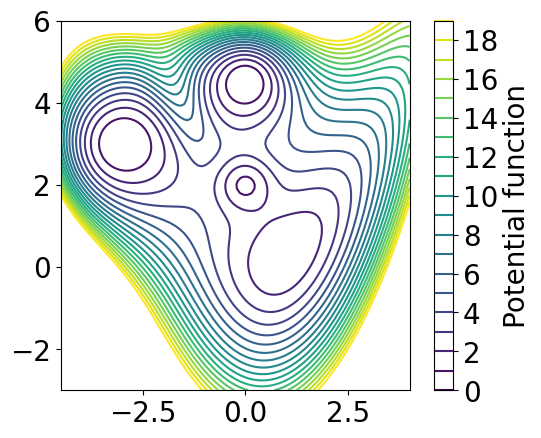

In [4]:
# Plot levelsets of the face potential
nx,ny= (100,100)
nxy = nx*ny
# Define the computational domain
xmin = -4.5
xmax = 4
ymin = -3
ymax = 6
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
# Reshape meshgrid into 1D arrays to compute the potential
x_vec = np.reshape(x_grid, (nxy,1))
y_vec = np.reshape(y_grid, (nxy,1))
v = np.zeros(nxy)
print(x_vec.shape)
print(y_vec.shape)
xy = np.concatenate((x_vec,y_vec),axis=1)
print(xy.shape)
v = Vpot(xy)
v_grid = np.reshape(v,(nx,ny))    

plt.rcParams.update({'font.size': 20})
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)


# Euler-Maruyama algorithm for simulating SDEs
Ref.: Desmond Higham, *An Algorithmic Introduction to Numerical Simulation of Stochastic Differential Equations*, SIAM Review, Vol.43,No.3,pp.525–546 (2001). https://epubs.siam.org/doi/pdf/10.1137/S0036144500378302

The Euler-Maruyama method for the SDE
$$ dX_t = - \nabla V(X_t)dt + \sqrt{2\beta^{-1}}dW_t,\quad X_t\in\mathbb{R}^d,\quad X_0 = x$$
is: set $X_0 = x_0$, choose a time step $h$, and for $j=0,1,2,\ldots$ do
$$X_{j+1} = X_{j} - \nabla V(X_{j})h + W_j,\quad W_j\sim\mathcal{N}(0,2h\beta^{-1}),$$
i.e., $W_j$s are independent Gaussian random variable with mean zero and variance $2h\beta^{-1}$.

If we simulate the SDE long enough, the set of generated samples becomes distributed according to the invariant density that is the Gibbs density 
$$\mu(x) = Z^{-1}e^{-\beta V(x)},\quad Z = \int_{\mathbb{R}^d}e^{-\beta V(x)}dx.$$


0.2
M(a) =  [0. 0.]
M(b) =  [0. 0.]


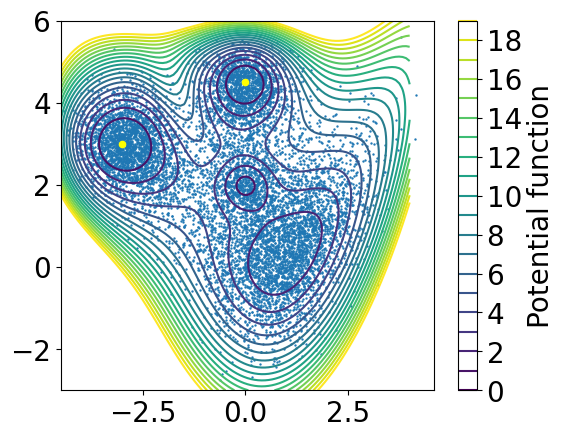

In [6]:
# Euler-Maruyama sampling
Ntraj = 1000000 # the number of time steps
h = 1e-2 # the time step size

ftraj_name = "Face_EMtraj_data.npz" # file name for the trajectory data

beta = 0.5 # choose high temperature (small beta) to make the trajectory less concentrated at the local minima

sqh = np.sqrt(h*2/beta) # the prefactor for the standard normal variable
print(sqh)
w = sqh*np.random.normal(0,1,(Ntraj-1,2)) # precompute the random variables for Euler-Maruyama

if Flag_EM_traj == True:
    # initial point
    xa = 0
    ya = 0
    p = np.zeros((Ntraj,2)) # initialize the array for the trajectory data
    p[0,:] = [xa,ya] 

    # Euler-Maruyama method
    for k in range(Ntraj-1):
        p[k+1,:] = p[k,:] - Vgrad(p[k,:])*h + w[k,:] 

    # save trajectory data 
    np.savez(ftraj_name,trajectory = p)
else:
    data = np.load(ftraj_name)
    p = data['trajectory']


# graphics
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
# Subsample the trajectory data equidistantly in time
skip = 100 
plt.scatter(p[0:Ntraj:skip,0],p[0:Ntraj:skip,1],s=0.5)

# Mark the "eye" minima of the face potential
minimum_a = np.array([-3,3]) 
minimum_b = np.array([0,4.5])
print('M(a) = ',Vgrad(minimum_a))
print('M(b) = ',Vgrad(minimum_b))
plt.scatter(minimum_a[0],minimum_a[1],c = "yellow",s=20)
plt.scatter(minimum_b[0],minimum_b[1],c = "yellow",s=20)

# Metadynamics 
[1]. Laio, A., and Parrinello, M. (2002). Escaping free-energy minima. Proceedings of the National Academy of Sciences, 99(20), 12562–12566

Here is a demo video by G. Bussi: https://www.youtube.com/watch?v=QP5F83g1G0E   

The metadynamics algorithm is an enhanced sampling technique. The idea is to fill the potential energy landscape of the free energy landscape of the system with Gaussian bumps to flatten it within a sublevel set of the potential or free energy function. As a result, the samples generated in the modified potential, that is a sum of the original potential function $V(x)$ and the potential $G(x)$ equal to the summ of all added Gaussian bumps For a 2D SDE, the metadynamics is implemented as follows. 

### The metadynamics algorithm
Choose  the number of steps between the deposition of Gausiian bumps $N_{\sf skip}$, the total number of Gaussian bumps to be deposited $N_{\sf bumps}$, the height of the Gaussian bumps $h_0$, and the width of the Gaussian bumps $\sigma$.

**for** $k = 0, \ldots, N_{\sf bumps}-1$ **do**

* Perform $N_{\sf skip}$ Euler-Maruyama steps in the potential $V + \sum_{j < k}B_j$, where $B_j$ is the $j$th Gaussian bump of the form 
$$ B_j = h_0\exp\left(-\frac{\|x-x_j\|^2}{2\sigma^2}\right),$$
where $x_j$ is the postion of the system at the time of the deposition of the bump $B_j$.

* Deposit the $k$th Gaussian bump: $B_k = h_0\exp\left(-\frac{\|x-x_k\|^2}{2\sigma^2}\right)$, where $x_k$ is the current position of the system.

**end for**

Note that all the Gaussian bumps have the same height. This results in the final potential being somewhat bumpy, i.e., it has small features of the width and height comparable to the width and height of the bumps.


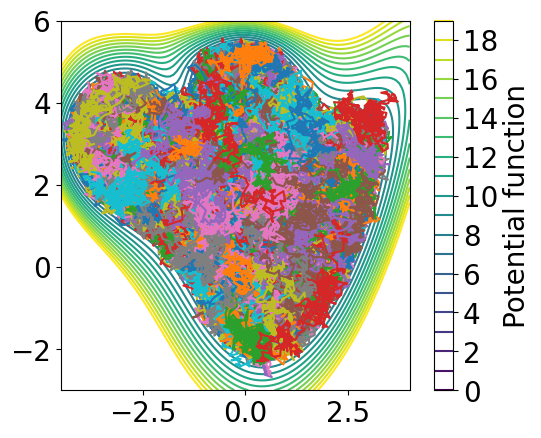

In [8]:
# Metadynamics algorithm
# Parameters for metadynamics
Nskip = 500 # steps between deposition of bumps
Nbumps = 1000 # the desired number of Gaussian bumps
height_0 = 0.3 # the height of the Gaussian bumps
sig = 0.3 # the width parameter of the Gaussian bumps
sig2 = sig**2

beta = 3.0 # use the value of beta we are interested in

h = 0.01 # time step 
sqh = np.sqrt(h*2/beta) # prefactor for the standard normal variable 
traj = np.zeros((Nskip,2)) # initialize the trajectory between deposits
xbump = np.zeros((Nbumps,2)) # initialize the array of bump centers

# initial point
x0 = minimum_a

ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
for k in range(Nbumps):
    traj[0,:] = x0   
    w = sqh*np.random.normal(0,1,(Nskip-1,2))
    if k == 0: # before a ny bumps are deposited
        for j in range(Nskip-1):
            traj[j+1,:] = traj[j,:] - h*Vgrad(traj[j,:]) + w[j,:]
    else: # if at least one bump is deposited    
        for j in range(Nskip-1):
            aux = np.outer(np.ones((k,)),traj[j,:]) - xbump[:k,:] # array [x-x_j,y-y_j] where (x_j,y_j) are bump centers
            exp = np.exp(-(0.5/sig2)*np.sum(aux**2,axis = 1)) # exp(-((x - x_j)^2 + (y - y_j)^2)/(2*sigma^2))
            dVbump = -(height_0/sig2)*np.sum(aux*np.outer(exp,np.ones((2,))),axis = 0)
            traj[j+1,:] = traj[j,:] - h*(Vgrad(traj[j,:])+dVbump) + w[j,:]
    plt.plot(traj[:,0],traj[:,1]) # plot the trajectory between bumps
    # deposit bump
    x0 = traj[j+1,:]
    xbump[k,:] = x0

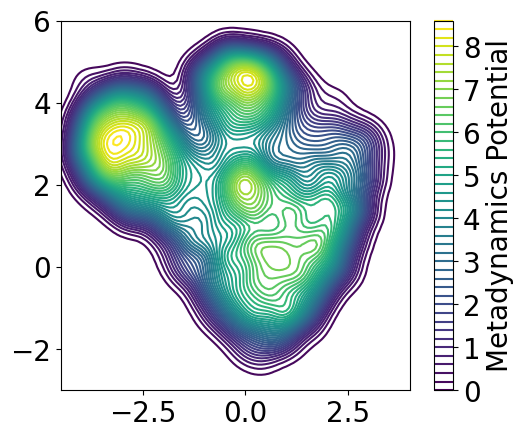

In [9]:
# Visualize the deposited potential of Gaussian bumps
def Metad_pot(xy,height,xbump,sig):
    N = np.size(xy, axis = 0)
    G = np.zeros((N,))
    s2 = 0.5/(sig**2)
    Nbumps = np.size(xbump,axis = 0)
    for j in range(N):
        aux = np.outer(np.ones((Nbumps,)),xy[j,:]) - xbump
        exp = np.exp(-s2*np.sum(aux**2,axis = 1))
        G[j] = height*np.sum(exp) 
    return G   
    
G = Metad_pot(xy,height_0,xbump,sig)
G_grid = np.reshape(G,(nx,ny))  

ls = plt.contour(x_grid,y_grid,G_grid,np.arange(0,np.max(G),0.2))
plt.colorbar(label="Metadynamics Potential", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

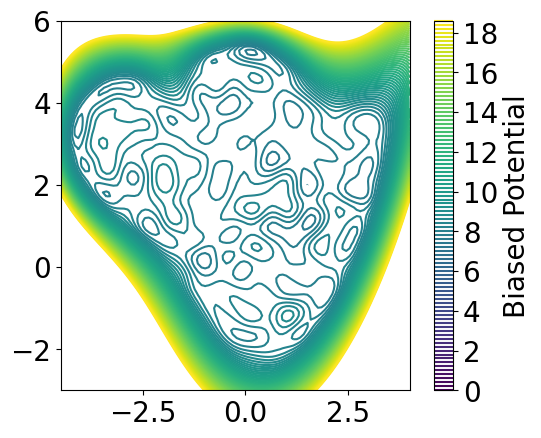

In [10]:
# Visualize the biased potential
ls = plt.contour(x_grid,y_grid,G_grid+v_grid,np.arange(0,10+np.max(G),0.2))
plt.colorbar(label="Biased Potential", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

# Well-Tempered Metadynamics 
[2]. Alessandro Barducci, Giovanni Bussi, and Michele Parrinello (2008). Well-Tempered Metadynamics: A Smoothly Converging and Tunable Free-Energy Method. Phys. Rev. Lett. 100, 020603. DOI: https://doi.org/10.1103/PhysRevLett.100.020603

### The well-tempered metadynamics algorithm
differs from the metadynamics algorithm in that the height of the deposited bumps decays exponentially with the value of the added potential of Gaussian bumps at  the given location. Let now be the time to deposit bump $B_k$. Let $x_k$ be the current location of the system. Then 

$$ B_k = h_k\exp\left(-\frac{\|x-x_k\|^2}{2\sigma^2}\right),$$
where 

$$h_k = h_0\exp\left(-\frac{\sum_{j=0}^{k-1}B_j(x_k)}{\gamma}\right),$$
and $\gamma$ is the user-defined discount factor.

The resulting modified potential is less bumpy than the metadynamics potential. 


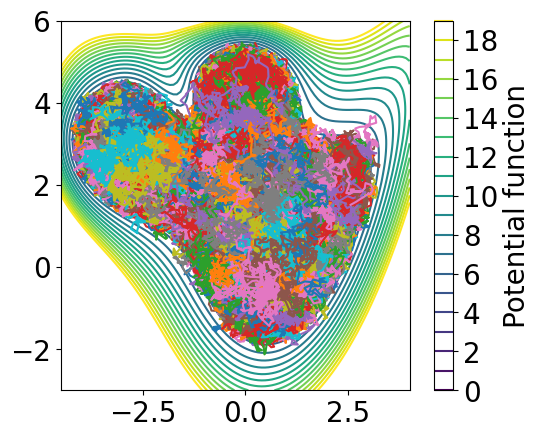

In [12]:
# Well-tempered metadynamics
# Metadynamics algorithm
# Parameters for metadynamics
Nskip = 500 # steps between deposition of bumps
Nbumps = 3000 # the desired number of Gaussian bumps
height_0 = 0.3 # the height of the Gaussian bumps
sig = 0.3 # the width parameter of the Gaussian bumps
sig2 = sig**2
gamma = 1. # the decay factor for the height
# height = height_0*exp(-(biasing_pot)/gamma);

beta = 3.0 # use the value of beta we are interested in

h = 0.01 # time step 
sqh = np.sqrt(h*2/beta) # prefactor for the standard normal variable 
traj = np.zeros((Nskip,2)) # initialize the trajectory between deposits
xbump = np.zeros((Nbumps,2)) # initialize the array of bump centers
height = np.zeros((Nbumps,)) # initialize the array of bump heights

# initial point
x0 = minimum_a

ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
for k in range(Nbumps):
    traj[0,:] = x0   
    w = sqh*np.random.normal(0,1,(Nskip-1,2))
    if k == 0: # before a ny bumps are deposited
        for j in range(Nskip-1):
            traj[j+1,:] = traj[j,:] - h*Vgrad(traj[j,:]) + w[j,:]
        biasing_pot = 0.    
    else: # if at least one bump is deposited    
        for j in range(Nskip-1):
            aux = np.outer(np.ones((k,)),traj[j,:]) - xbump[:k,:] # array [x-x_j,y-y_j] where (x_j,y_j) are bump centers
            exp = np.exp(-(0.5/sig2)*np.sum(aux**2,axis = 1)) # exp(-((x - x_j)^2 + (y - y_j)^2)/(2*sigma^2))
            dVbump = -np.sum(aux*np.outer(height[:k]*exp,np.ones((2,))),axis = 0)/sig2
            traj[j+1,:] = traj[j,:] - h*(Vgrad(traj[j,:])+dVbump) + w[j,:]
        biasing_pot = np.dot(height[:k],exp)    
    plt.plot(traj[:,0],traj[:,1]) # plot the trajectory between bumps
    # deposit bump
    x0 = traj[j+1,:]
    xbump[k,:] = x0
    height[k] = height_0*np.exp(-(biasing_pot)/gamma)

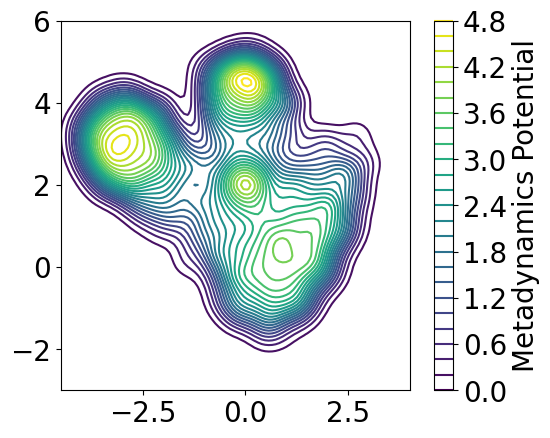

In [13]:
# Visualize the deposited potential of Gaussian bumps
def Metad_pot(xy,height,xbump,sig):
    N = np.size(xy, axis = 0)
    G = np.zeros((N,))
    s2 = 0.5/(sig**2)
    Nbumps = np.size(xbump,axis = 0)
    for j in range(N):
        aux = np.outer(np.ones((Nbumps,)),xy[j,:]) - xbump
        exp = np.exp(-s2*np.sum(aux**2,axis = 1))
        G[j] = np.dot(height,exp) 
    return G   
    
G = Metad_pot(xy,height,xbump,sig)
G_grid = np.reshape(G,(nx,ny))  

ls = plt.contour(x_grid,y_grid,G_grid,np.arange(0,np.max(G),0.2))
plt.colorbar(label="Metadynamics Potential", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

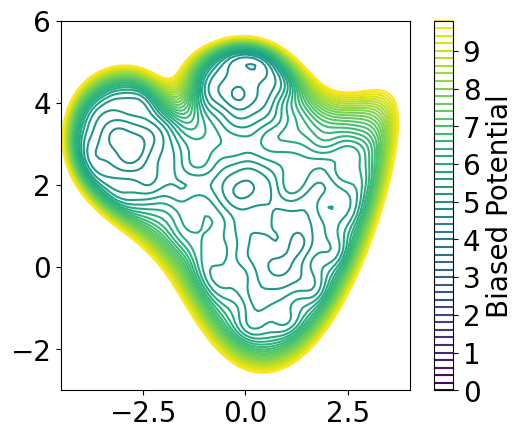

In [14]:
# Visualize the biased potential
ls = plt.contour(x_grid,y_grid,G_grid+v_grid,np.arange(0,10,0.2))
plt.colorbar(label="Biased Potential", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})

0.08164965809277261


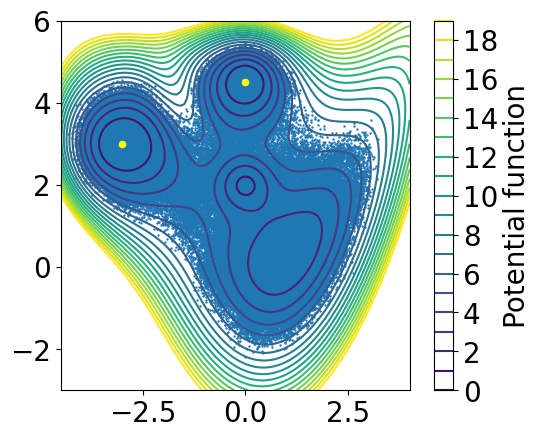

In [15]:
# Run a trajectory in the biased potential
# Euler-Maruyama sampling
Ntraj = 1000000 # the number of time steps
h = 1e-2 # the time step size

ftraj_name = "Face_WTMetad_traj_data.npz" # file name for the trajectory data

beta = 3 # choose high temperature (small beta) to make the trajectory less concentrated at the local minima

sqh = np.sqrt(h*2/beta) # the prefactor for the standard normal variable
print(sqh)
w = sqh*np.random.normal(0,1,(Ntraj-1,2)) # precompute the random variables for Euler-Maruyama

if Flag_WTMetad_traj == True:
    # initial point
    p = np.zeros((Ntraj,2)) # initialize the array for the trajectory data
    p[0,:] = minimum_a 

    # Euler-Maruyama method
    for j in range(Ntraj-1):
        aux = np.outer(np.ones((Nbumps,)),p[j,:]) - xbump # array [x-x_j,y-y_j] where (x_j,y_j) are bump centers
        exp = np.exp(-(0.5/sig2)*np.sum(aux**2,axis = 1)) # exp(-((x - x_j)^2 + (y - y_j)^2)/(2*sigma^2))
        dVbump = -np.sum(aux*np.outer(height*exp,np.ones((2,))),axis = 0)/sig2
        p[j+1,:] = p[j,:] - (Vgrad(p[j,:]) + dVbump)*h + w[j,:] 

    # save trajectory data 
    np.savez(ftraj_name,trajectory = p)
else:
    data = np.load(ftraj_name)
    p = data['trajectory']


# graphics
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
skip = 5 
plt.scatter(p[::skip,0],p[::skip,1],s=0.5)

# Mark the "eye" minima of the face potential
plt.scatter(minimum_a[0],minimum_a[1],c = "yellow",s=20)
plt.scatter(minimum_b[0],minimum_b[1],c = "yellow",s=20)


# Delta-net
It is often desirable to produce a set of samples uniformly distributed within a sublevel set of the potential function $V(x)$. Well-tempered metadynamics can, in principle, flatten the potential within its certain sublevel set, but this require a lot of parameter tuning. Furthermore, it is often beneficial to have a dataset of points not independent identically distributed but making up a uniform mesh points, i.e., with a distance close to the desired distance $\delta$ between nearest neighbors. We generate a quasiuniform dataset as follows.

* Run well-tempered metadynamics and generate a initial set of points $\mathcal{X}_0$.
* Subsample $\mathcal{X}_0$ to a reasonable size so that the generation of a quasiuniform set does not take too long, e.g., let $\mathcal{X}_1$ consist of every $s$th point of $\mathcal{X}_0$. Let $\mathcal{X}_1$ have $N$ points.
* Make a 1D array ${\sf mask}$ of the same length as $\mathcal{X}_1$  consisting of ones. Value one means "keep", while value zero means "remove".
* Set $k = 0$. Choose $\delta > 0$.
* **while** $k < N$ **do**:
    - Find all points at distance less than $\delta$ from $x_k$ and and set ${\sf mask} = 0$ at them. 
    - Find the point with the smallest index $l$ in $\mathcal{X}_1$ such that $l > k$ **and**  ${\sf mask}[l] = 1$. Set $k = 1$.
*  **end while**
*  Define $\mathcal{X}_2 = \mathcal{X}_1[{\sf mask} == 1]$. We call the resulting set  $\mathcal{X}_2$ the **delta-net**.

In [17]:
# make a delta-net
skip = 2
data = p[::skip,:]
Ndata = np.size(data,axis = 0)
delta = 0.05
delta2 = delta**2
k = 0
mask = np.ones(Ndata,dtype=np.int64)
while k < Ndata:
    ind = np.argwhere((data[:,0]-data[k,0])**2+(data[:,1]-data[k,1])**2 < delta2)
    mask[ind] = 0
    mask[k] = 1
    iremain = np.argwhere(mask[k+1:]==1)
    if np.any(iremain):
        k = k + 1 + np.amin(iremain)
    else:
        k = Ndata

(8044, 2)


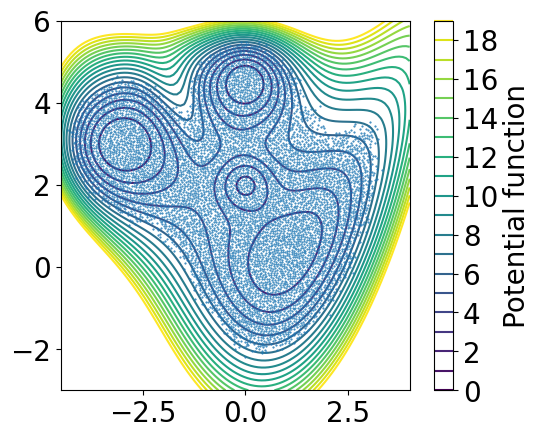

In [18]:
ls = plt.contour(x_grid,y_grid,v_grid,range(0,20))
plt.colorbar(label="Potential function", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
step = 10
ind = np.argwhere(mask == 1)
face_delta_net = np.squeeze(data[ind,:])

plt.plot(face_delta_net[:,0],face_delta_net[:,1],'.',markersize = 1)

print(np.shape(face_delta_net))

fname = "Face_DeltaNet.npz"
np.savez(fname,delta_net = face_delta_net)